# 13.4 無限時間最適制御モデル (infinite-horizon optimal feedback control model)

## 13.4.1 モデルの構造
> Qian N, Jiang Y, Jiang ZP, Mazzoni P. Movement duration, Fitts's law, and an infinite-horizon optimal feedback control model for biological motor systems. Neural Comput. 2013.


$$
\begin{array}{l}
d x=(A x+B u) d t +Y u d \gamma+G d \omega \\
d y=C x d t+D d \xi\\
d \hat{x}=(A \hat{x}+B u) d t+K(d y-C \hat{x} d t)
\end{array}
$$

## 13.4.2 実装
ライブラリの読み込みと関数の定義．

In [1]:
using LinearAlgebra, Kronecker, Random, BlockDiagonals, PyPlot

In [2]:
eye(T::Type, n) = Diagonal{T}(I, n)
eye(n) = eye(Float64, n)
vec(X) = vcat(X...)

vec (generic function with 1 method)

定数の定義

$$
\begin{align}
\alpha_{1}=\frac{b}{t_{a} t_{e} I}, \alpha_{2}=\frac{1}{t_{a} t_{e}}+\left(\frac{1}{t_{a}}+\frac{1}{t_{e}}\right) \frac{b}{I} \\
\alpha_{3}=\frac{b}{I}+\frac{1}{t_{a}}+\frac{1}{t_{e}}, b_{u}=\frac{1}{t_{a} t_{e} I}
\end{align}
$$

In [3]:
n = 4 # number of dims
i = 0.25 # kgm^2, 
b = 0.2 # kgm^2/s
ta = 0.03 # s
te = 0.04 # s
L0 = 0.35 # m

bu = 1 / (ta * te * i)
α1 = bu * b
α2 = 1/(ta * te) + (1/ta + 1/te) * b/i
α3 = b/i + 1/ta + 1/te

A = [zeros(3) eye(3); -[0, α1, α2, α3]']
B = [zeros(3); bu]
C = [eye(3) zeros(3)]
D = Diagonal([1e-3, 1e-2, 5e-2])

Y = 0.02 * B
G = 0.03 * eye(n)

Q = Diagonal([1.0, 0.01, 0, 0]) 
R = 0.0001
U = Diagonal([1.0, 0.1, 0.01, 0]);

$$
\begin{array}{l}
X \equiv\left[\begin{array}{l}
x \\
\tilde{x}
\end{array}\right], d \bar{\omega} \equiv\left[\begin{array}{c}
d \omega \\
d \xi
\end{array}\right], \bar{A} \equiv\left[\begin{array}{cc}
A-B L & B L \\
0 & A-K C
\end{array}\right] \\
\bar{Y} \equiv\left[\begin{array}{cc}
-Y L & Y L \\
-Y L & Y L
\end{array}\right], \bar{G} \equiv\left[\begin{array}{cc}
G & 0 \\
G & -K D
\end{array}\right]
\end{array}
$$

とする．元論文では$F, \bar{F}$が定義されていたが，$F=0$とするため，以後の式から削除した．

$$
\begin{array}{l}
P \equiv\left[\begin{array}{cc}
P_{11} & P_{12} \\
P_{12} & P_{22}
\end{array}\right] \equiv E\left[X X^{T}\right] \\
V \equiv\left[\begin{array}{cc}
Q+L^{T} R L & -L^{T} R L \\
-L^{T} R L & L^{T} R L+U
\end{array}\right]
\end{array}
$$

$$
\begin{align}
&K=P_{22} C^{T}\left(D D^{T}\right)^{-1} \\
&L=\left(R+Y^{T}\left(S_{11}+S_{22}\right) Y\right)^{-1} B^{T} S_{11} \\
&\bar{A}^{T} S+S \bar{A}+\bar{Y}^{T} S \bar{Y}+V=0 \\
&\bar{A} P+P \bar{A}^{T}+\bar{Y} P \bar{Y}^{T}+\bar{G} \bar{G}^{T}=0
\end{align}
$$


$A = (a_{ij})$ を $m \times n$ 行列，$B = (b_{kl})$ を $p \times q$ 行列とすると、それらのクロネッカー積 $A \otimes B$ は

$$
A\otimes B={\begin{bmatrix}a_{11}B&\cdots &a_{1n}B\\\vdots &\ddots &\vdots \\a_{m1}B&\cdots &a_{mn}B\end{bmatrix}}
$$

で与えられる $mp \times nq$ 区分行列である．

Roth's column lemma (vec-trick) 

$$
(B^\top \otimes A)\text{vec}(X) = \text{vec}(AXB)=\text{vec}(C)
$$

によりこれを解くと，

$$
\begin{align}
S &= -\text{vec}^{-1}\left(\left(I^\top \otimes \bar{A}^\top + \bar{A}^\top \otimes I + \bar{Y}^\top \otimes \bar{Y}^\top\right)^{-1}\text{vec}(V)\right)\\
P &= -\text{vec}^{-1}\left(\left(I^\top \otimes \bar{A} + \bar{A} \otimes I + \bar{Y} \otimes \bar{Y}\right)^{-1}\text{vec}(\bar{G}\bar{G}^\top)\right)
\end{align}
$$



### K, L, S, Pの計算
1. LとKをランダムに初期化
2. SとPを計算
3. LとKを更新
4. 収束するまで2と3を繰り返す．

収束スピードはかなり速い．

In [4]:
maxiter = 1000
eps = 1e-8

# initialize
L = rand(n)' # Feedback gains
K = rand(n, 3) # Kalman gains
I2n = eye(2n)

for i in 1:maxiter
    Ā = [A-B*L B*L; zeros(size(A)) (A-K*C)]
    Ȳ = [-ones(2) ones(2)] ⊗ (Y*L) 
    Ḡ = [G zeros(size(K)); G (-K*D)]
    V = BlockDiagonal([Q, U]) + [1 -1; -1 1] ⊗ (L'* R * L)
    
    # update S, P
    S = -reshape((I2n' ⊗ (Ā)' +  (Ā)' ⊗ I2n + (Ȳ)' ⊗ (Ȳ)')^-1 * vec(V), (2n, 2n))
    P = -reshape((I2n' ⊗ Ā +  Ā ⊗ I2n + Ȳ ⊗  Ȳ)^-1 * vec(Ḡ * (Ḡ)'), (2n, 2n))

    # update K, L
    P22 = P[n+1:2n, n+1:2n]
    S11 = S[1:n, 1:n]
    S22 = S[n+1:2n, n+1:2n]

    Ktm1 = copy(K)
    Ltm1 = copy(L)

    K = P22 * C' * (D * D')^-1
    L = (R + Y' * (S11 + S22) * Y)^-1 * B' * S11
    if sum(abs.(K - Ktm1)) < eps && sum(abs.(L - Ltm1)) < eps
        break
    end
end

### 理想状況でのシミュレーション

In [5]:
dt = 0.001 # sec
T = 2.0 # sec
nt = round(Int, T/dt)
Xa = zeros(4, nt)
ua = zeros(nt)
Xa[1, 1] = -0.5 # m; initial position (target position is zero)

for k=1:nt-1
    ua[k] = -L * Xa[:, k]
    Xa[:, k+1] = Xa[:,k] + (A * Xa[:,k] + B * ua[k]) * dt
end

### ノイズを含むシミュレーション

In [6]:
sqrtdt = √dt
nsim = 10
XSimAll = zeros(nsim, 4, nt)
uSimAll = zeros(nsim, nt)
for i in 1:nsim
    XSim = zeros(4, nt)
    Xhat = zeros(4, nt)
    u = zeros(nt)
    XSim[1, 1] = -0.5 # m; initial position (target position is zero)
    Xhat[1, 1] = XSim[1, 1]
    
    for k=1:nt-1
        u[k] = -L * Xhat[:, k]
        XSim[:, k+1] = XSim[:,k] + (A * XSim[:,k] + B * u[k]) * dt + sqrtdt * (Y * u[k] * randn() + G * randn(n))
        dy = C * XSim[:,k] * dt + D * sqrtdt * randn(n-1)
        Xhat[:, k+1] = Xhat[:,k] + (A * Xhat[:,k] + B * u[k]) * dt + K * (dy - C * Xhat[:,k] * dt)
    end
    XSimAll[i,:,:] = XSim
    uSimAll[i, :] = u
end

### 結果の描画

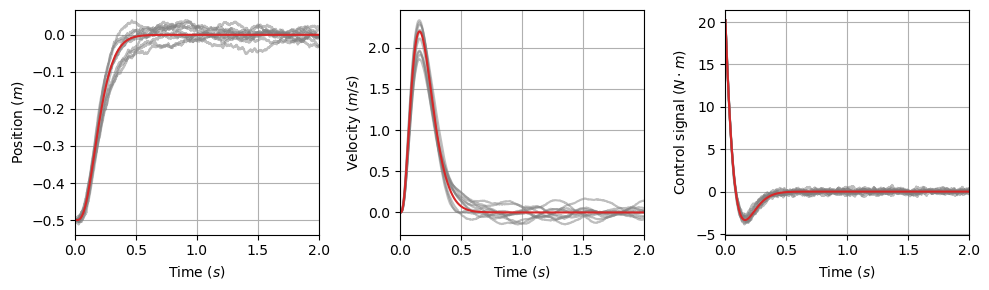

In [7]:
tarray = (1:nt) * dt
label = [L"Position ($m$)", L"Velocity ($m/s$)", L"Acceleration ($m/s^2$)", L"Jerk ($m/s^3$)"]
figure(figsize=(10, 3))
for i in 1:2
    subplot(1,3,i)
    plot(tarray, XSimAll[:,i,:]', "tab:gray", alpha=0.5)
    plot(tarray, Xa[i,:], "tab:red")
    ylabel(label[i]); xlabel(L"Time ($s$)"); xlim(0, T); grid()
end
subplot(1,3,3)
plot(tarray, uSimAll', "tab:gray", alpha=0.5)
plot(tarray, ua, "tab:red")
ylabel(L"Control signal ($N\cdot m$)"); xlabel(L"Time ($s$)"); xlim(0, T); grid()

tight_layout()

## 13.4.3 Target jump

> Li Z, Mazzoni P, Song S, Qian N. A Single, Continuously Applied Control Policy for Modeling Reaching Movements with and without Perturbation. Neural Comput. 2018.

In [8]:
T = 1.0   # sec
Ttj = 0.4 # target jumping timing (sec)
nt = round(Int, T/dt)
ntj = round(Int, Ttj/dt)
tj_dist = 0.1; # target jump distance

In [9]:
Xtj = zeros(4, nt)
utj = zeros(nt)
Xtj[1, 1] = -0.5 # m; initial position (target position is zero)

for k=1:nt-1
    if k == ntj
        Xtj[1,k] -= tj_dist # When k == ntj, target jumpさせる（実際には現在の位置をずらす）
    end
    utj[k] = -L * Xtj[:, k]
    Xtj[:, k+1] = Xtj[:,k] + (A * Xtj[:,k] + B * utj[k]) * dt
end

Xtj[1, 1:ntj-1] .-= tj_dist;

In [10]:
XtjAll = zeros(nsim, 4, nt)
utjAll = zeros(nsim, nt)
for i in 1:nsim
    XSim = zeros(4, nt)
    Xhat = zeros(4, nt)
    u = zeros(nt)
    XSim[1, 1] = -0.5 # m; initial position (target position is zero)
    Xhat[1, 1] = XSim[1, 1]
    
    for k=1:nt-1
        if k == ntj
            XSim[1,k] -= tj_dist
            Xhat[1,k] -= tj_dist
        end
        u[k] = -L * Xhat[:, k]
        XSim[:, k+1] = XSim[:,k] + (A * XSim[:,k] + B * u[k]) * dt + sqrtdt * (Y * u[k] * randn() + G * randn(n))
        dy = C * XSim[:,k] * dt + D * sqrtdt * randn(n-1)
        Xhat[:, k+1] = Xhat[:,k] + (A * Xhat[:,k] + B * u[k]) * dt + K * (dy - C * Xhat[:,k] * dt)
    end
    XtjAll[i,:,:] = XSim
    utjAll[i, :] = u
end

XtjAll[:, 1, 1:ntj-1] .-= tj_dist;

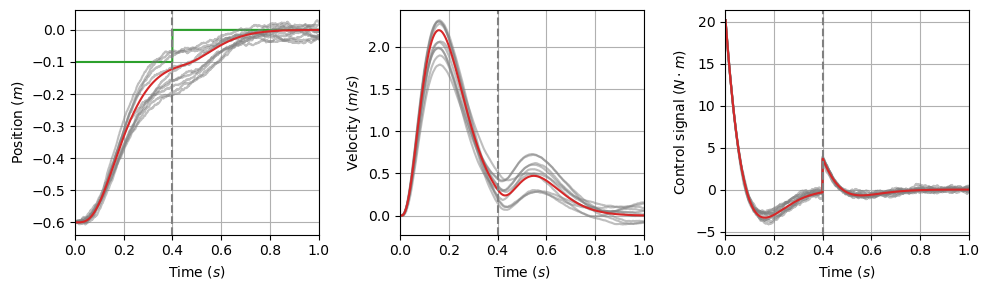

In [11]:
tarray = (1:nt) * dt
target_pos = zeros(nt)
target_pos[1:ntj-1] .-= tj_dist; 

figure(figsize=(10, 3))
for i in 1:2
    subplot(1,3,i)
    if i == 1
        plot(tarray, target_pos, "tab:green")
    end
    plot(tarray, XtjAll[:,i,:]', "tab:gray", alpha=0.5)
    plot(tarray, Xtj[i,:], "tab:red")
    axvline(x=Ttj, color="gray", linestyle="dashed")
    ylabel(label[i]); xlabel(L"Time ($s$)"); xlim(0, T); grid()
     
end
subplot(1,3,3)
plot(tarray, utjAll', "tab:gray", alpha=0.5)
plot(tarray, utj, "tab:red")
axvline(x=Ttj, color="gray", linestyle="dashed")
ylabel(L"Control signal ($N\cdot m$)"); xlabel(L"Time ($s$)"); xlim(0, T); grid()

tight_layout()